In [2]:
import os
import re
import random
import requests
import pickle
import pandas as pd
import numpy as np
import multiprocessing

import conllu

import nltk
from nltk import FreqDist
from nltk.corpus import stopwords

from sklearn.manifold import TSNE 

from gensim import corpora, downloader
from gensim.utils import simple_preprocess, tokenize
from gensim.models import KeyedVectors, Word2Vec
from gensim.test.utils import datapath
from gensim.models.fasttext import FastText

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import warnings

import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline


warnings.filterwarnings('ignore')


In [3]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ruathudo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ruathudo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
BATCH_SIZE = 500
EMBEDDING_SIZE = 300  # Dimension of the embedding vector
WINDOW_SIZE = 5  # How many words to consider left and right
NEG_SAMPLE_NUM = 10  # Number of negative examples to sample
MIN_COUNT = 5 # The words have less than this freq will be ignored
LR = 0.01
N_EPOCH=20
REPORT_EVERY=1
# check if GPU available
USE_CUDA = torch.cuda.is_available()

WORKERS = multiprocessing.cpu_count()

device = torch.device("cuda" if USE_CUDA else "cpu")
torch.set_num_threads(WORKERS)
np.random.seed(12)
print(device, WORKERS)
LANG = 'english'

cpu 8


# Handle dataset

In [5]:
def get_conll_dataset(lang='en'):
    """
    Get dataset from github repo: https://github.com/ufal/rh_nntagging
    """
    files = []
    repo = 'https://raw.githubusercontent.com/ufal/rh_nntagging/master/data/ud-1.2/'
    urls = {"train": os.path.join(repo, lang, lang+'-ud-train.conllu'),
            "dev": os.path.join(repo, lang, lang+'-ud-dev.conllu'),
            "test": os.path.join(repo, lang, lang+'-ud-test.conllu'),}
    
    # create language folder if not exist
    if not os.path.exists('data/'+lang):
        os.makedirs('data/'+lang)
    
    for filename, url in urls.items():
        filepath = os.path.join(os.getcwd(), 'data', lang, filename + '.conllu')
        files.append((filename, filepath))
        
        # check if already downloaded
        if os.path.isfile(filepath):
            continue
        
        r = requests.get(url, allow_redirects=True)
        
        with open(filepath, 'wb') as output:
            output.write(r.content)
            
    return files


def read_text_dataset(filename):
    """
    This handle the free text file, not in conllu format
    """
    with open(filename) as f:
        data = f.read()
        sentences = re.split(r' *[\.\?!][\'"\)\]]* *', data)
        
        tokenized_sentences = []
        
        for s in sentences:
            # clean text of websites, email address and any punctuation
            text = re.sub(r"((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", s)
            tokens = simple_preprocess(text)
            tokenized_sentences.append(tokens)
    
    return tokenized_sentences

def get_gensim_dataset(name):
    corpus = downloader.load(name)
    # gensim return a interable object which is list of tokenized corpus
        
    return corpus

def parse_conll(files):
    """
    Because the dataset in conllu format, so we need to parse it for processing
    """
    data = {}
    for file in files:
        with open(file[1], "r", encoding="utf-8") as f:
            sentences = list(tokens for tokens in conllu.parse_incr(f))
        data[file[0]] = sentences
        
    return data


def clean_data(data, lang='english'):
    sentences = []
    stop_words = set(stopwords.words(lang))
    
    for sentence in data:
        text = []
        for token in sentence:
            # token object is OrderDict type with lemma as one key
            # It looks like this
            # OrderedDict([('id', 1), ('form', 'What'), ('lemma', 'what'), ('upostag', 'PRON')])
            text.append(token['lemma'])
        # merge list to string  
        text = ' '.join(text)
        # clean text of websites, email address and any punctuation
        text = re.sub(r"((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
        # tokenize with gensim
        tokens = simple_preprocess(text)
        # clean stop words
        tokens = [w for w in tokens if not w in stop_words]
        sentences.append(tokens)
        
    return sentences


In [6]:
%%time
# download the dataset
files = get_conll_dataset(lang=LANG[:2])

# parse the conllu format to python object
# return data = {"dev": sentences, "train": sentences, "test": sentences}
data = parse_conll(files)

# clean and tokenize the data
train_data = clean_data(data['train'], lang=LANG)
dev_data = clean_data(data['dev'], lang=LANG)
test_data = clean_data(data['test'], lang=LANG)

CPU times: user 7.7 s, sys: 195 ms, total: 7.9 s
Wall time: 26.5 s


In [7]:
print("train data length:", len(train_data))
print("dev data length:", len(dev_data))
print("test data length:", len(test_data))


train data length: 12543
dev data length: 2002
test data length: 2077


In [8]:
# This also support read the data set from normal text file
# and from gensim dataset

# test read text file
# text_data = read_text_dataset('trainset.txt')
# len(text_data)

# test get gensim corpus
# gs_data = get_gensim_dataset('text8')

# Data processing

In [9]:
class DataProcess:
    SUB_THRESHOLD = 1e-5
    NEG_THRESHOLD = 0.75
    neg_sample_tbl = []
    sub_sample_tbl = []
    
    def __init__(self,
                 corpus: list=(list,),
                 batch_size: int=20,
                 neg_sample_num: int=5,
                 window_size: int=2,
                 min_freq: int=5):
        
        self.corpus = corpus
        self.batch_size = batch_size
        self.neg_sample_num = neg_sample_num
        self.window_size = window_size
        self.min_freq = min_freq

    def gen_vocab(self):
        """
        Create vocab dictionary
        """
        # flatten list of tokens in corpus
        tokens = sum(self.corpus, [])
        
        # calculate freq of words
        freq_dist = FreqDist(tokens)
        
        vocab, word2idx, idx2word = {}, {}, {}
        
        index = 0
        for word, freq in freq_dist.items():
            # ignore the word has freq less than min_freq
            if freq < self.min_freq:
                continue
            vocab[word] = freq    
            word2idx[word] = index
            idx2word[index] = word
            index += 1
        
        return vocab, word2idx, idx2word
    
    def gen_word_pairs(self, word2idx):
        window_size = self.window_size
        
        idx_pairs = []
        # for each sentence in tokenized corpus
        for sentence in self.corpus:
            indices = [word2idx[w] for w in sentence if w in word2idx]
            
            # select center word
            for center_word_pos in range(len(indices)):
                # for each window position
                for w in range(-window_size, window_size + 1):
                    context_word_pos = center_word_pos + w
                    # make sure not jump out sentence
                    if context_word_pos < 0 or context_word_pos >= len(indices) or center_word_pos == context_word_pos:
                        continue
                    context_word_idx = indices[context_word_pos]
                    idx_pairs.append((indices[center_word_pos], context_word_idx))
                    
        # convert to numpy for faster calculation
        idx_pairs = np.array(idx_pairs)
        
        return idx_pairs
    
        
    def gen_negative_sample_table(self, freqs):
        """
        params: freqs is the list of dict {idx: freq} of word
        As mentioned in the blog: http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/
        
        implemented same as word2vec c code.
        The way this selection is implemented in the C code is interesting. They have a large array with 100M elements
        (which they refer to as the unigram table). They fill this table with the index of each word in the vocabulary
        multiple times, and the number of times a word’s index appears in the table is given by P(wi) * table_size.

            p(w_i) = f(w_i) ** neg_sampling / sum(f(w_i) ** neg_sampling for w_i in vocab)
        """
        # init 100M sample table
        sample_tbl_size = 1e8
        sample_tbl = []
        
        # calculate the probability for each word by multiply with neg_threshold = 0.75
        pow_freq = np.array(list(freqs.values())) ** self.NEG_THRESHOLD
        # Sum the prob of all words
        pow_total_freq = sum(pow_freq)
        # calculate the ratio for filter
        r = pow_freq / pow_total_freq
        # calculate how many samples each word takes to fill to table
        n_samples = np.round(r * sample_tbl_size)
        
        # Now fill n_samples (by id) to the table
        for word, count in enumerate(n_samples):
            sample_tbl += [word] * int(count)
            
        # convert to np array for fast calculation
        self.neg_sample_tbl = np.array(sample_tbl)
        
        return self.neg_sample_tbl

    def get_neg_sample(self, idx1, idx2):
        """
        get negative sample from table, not equal to input and context word
        """
        negs = []
        
        while len(negs) < self.neg_sample_num:
            samples = np.random.choice(self.neg_sample_tbl, size=self.neg_sample_num - len(negs))
            negs += [i for i in samples if i != idx1 and i != idx2 and i not in negs]

        return negs

    def gen_batches(self, word2idx, idx_pairs):
        """
        generate batches
        from pairs of input and context words + list of negative sampling
        [[u, u, u], [v, v, v], [[neg, neg], [neg, neg], [neg, neg]]]
        """
        
        batches = []
        
        for i in range(0, len(idx_pairs), self.batch_size):
            inputs, contexts, neg_samples = [], [], []
            
            for pair in idx_pairs[i: i + self.batch_size]:
                inputs.append(pair[0])
                contexts.append(pair[1])
                neg_samples.append(self.get_neg_sample(pair[0], pair[1]))
                
            batches.append([inputs, contexts, neg_samples])
            
        return batches
    
    def pipeline(self):
        # generate vocab dictionary
        vocab, word2idx, idx2word = self.gen_vocab()
        
        # generate input and context words pair
        idx_pairs = self.gen_word_pairs(word2idx)
        
        # generate negative sample table
        self.gen_negative_sample_table(vocab)
        
        # create batches
        batches = self.gen_batches(word2idx, idx_pairs)
        
        return batches, vocab, word2idx, idx2word
        


In [10]:
processor = DataProcess(corpus=train_data, 
                        batch_size=BATCH_SIZE, 
                        neg_sample_num=NEG_SAMPLE_NUM, 
                        window_size=WINDOW_SIZE,
                        min_freq=MIN_COUNT)

In [11]:
# vocab, word2idx, idx2word = processor.gen_vocab()
# idx_pairs = processor.gen_word_pairs(word2idx)
# processor.gen_negative_sample_table(vocab)
# batches = processor.gen_batches(word2idx, idx_pairs)

In [12]:
# with open('data/vocab.pkl', 'wb') as output:
#     pickle.dump(vocab, output, -1)
    
# with open('data/word2idx.pkl', 'wb') as output:
#     pickle.dump(word2idx, output, -1)
    
# with open('data/idx2word.pkl', 'wb') as output:
#     pickle.dump(idx2word, output, -1)

In [13]:
%%time
batches, vocab, word2idx, idx2word = processor.pipeline()

CPU times: user 23.4 s, sys: 464 ms, total: 23.8 s
Wall time: 23.8 s


In [14]:
len(batches)

899

# Skip Gram Model

In [15]:
# Now we create skip gram model with negative sampling

In [16]:
class SkipGramModel(nn.Module):
    """
    Skip-Gram model
    """
    def __init__(self, vocab_size: int, emb_dim: int=200):
        super(SkipGramModel, self).__init__()
        
        self.vocab_size = vocab_size
        self.emb_dim = emb_dim
        
        self.u_embeddings = nn.Embedding(vocab_size, emb_dim, sparse=True)
        self.v_embeddings = nn.Embedding(vocab_size, emb_dim, sparse=True)
        self.init_emb()

    def init_emb(self):
        """
        init the weight as original word2vec
        """
        initrange = 0.5 / self.emb_dim
        self.u_embeddings.weight.data.uniform_(-initrange, initrange)
        self.v_embeddings.weight.data.uniform_(0, 0)

    def forward(self, pos_u, pos_v, neg_v):
        """
        forward process.
        the pos_u and pos_v shall be the same size.
        the neg_v shall be {negative_sampling_count} * size_of_pos_u
        eg:
        5 sample per batch with 300d word embedding and 10 times neg sampling.
        pos_u 5 * 300
        pos_v 5 * 300
        neg_v 5 * 10 * 300

        :param pos_u:  positive pairs u, list
        :param pos_v:  positive pairs v, list
        :param neg_v:  negative pairs v, list
        """
        emb_u = self.u_embeddings(pos_u)  # batch_size * emb_size
        emb_v = self.v_embeddings(pos_v)  # batch_size * emb_size
        emb_neg = self.v_embeddings(neg_v)  # batch_size * neg sample size * emb_size

        pos_score = torch.mul(emb_u, emb_v).squeeze()
        pos_score = torch.sum(pos_score, dim=1)
        pos_score = F.logsigmoid(pos_score)

        neg_score = torch.bmm(emb_neg, emb_u.unsqueeze(2)).squeeze()
        neg_score = F.logsigmoid(-neg_score)
        
        loss = torch.sum(pos_score) + torch.sum(neg_score)

        return -1*loss
    
    def save(self, filepath, idx2word):
        """
        Save the word vectors as standard word2vec format
        """
        embeds = self.u_embeddings.weight.cpu().data.numpy()
        fout = open(filepath, 'w', encoding='utf-8')
        
        fout.write('%d %d\n' % (len(idx2word), self.emb_dim))
        
        for idx, word in idx2word.items():
            emb = ' '.join(map(str, embeds[idx]))
            fout.write('%s %s\n' % (word, emb))


In [17]:
vocab_size = len(word2idx)

model = SkipGramModel(vocab_size=vocab_size, emb_dim=EMBEDDING_SIZE).to(device)

optimizer = optim.SGD(model.parameters(), lr=LR)

In [18]:
def train(batches):
    print('Start training')
    # print(self.data.gen_batch()[0])
    for epoch in range(N_EPOCH):
        total_loss = 0
        
        for minibatch in batches:
            pos_u = torch.tensor(minibatch[0], dtype=torch.long).to(device)
            pos_v = torch.tensor(minibatch[1], dtype=torch.long).to(device)
            neg_v = torch.tensor(minibatch[2], dtype=torch.long).to(device)

            # print(len(pos_u), len(pos_v), len(neg_v))
            optimizer.zero_grad()
            loss = model.forward(pos_u, pos_v, neg_v)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        if ((epoch+1) % REPORT_EVERY) == 0:
            print('epoch: %d, loss: %.4f' % (epoch+1, total_loss))
        

In [19]:
%%time
train(batches)

Start training
epoch: 1, loss: 2553086.4213
epoch: 2, loss: 1530130.3473
epoch: 3, loss: 1477419.6168
epoch: 4, loss: 1472808.4811
epoch: 5, loss: 1468606.4012
epoch: 6, loss: 1462029.5330
epoch: 7, loss: 1452901.6697
epoch: 8, loss: 1441805.4423
epoch: 9, loss: 1428678.2999
epoch: 10, loss: 1413960.4659
epoch: 11, loss: 1396661.1082
epoch: 12, loss: 1378457.2267
epoch: 13, loss: 1359128.8764
epoch: 14, loss: 1338878.2479
epoch: 15, loss: 1317922.4028
epoch: 16, loss: 1296382.7895
epoch: 17, loss: 1274370.2539
epoch: 18, loss: 1251999.3076
epoch: 19, loss: 1229359.6967
epoch: 20, loss: 1206557.8051
CPU times: user 20min 39s, sys: 42min 27s, total: 1h 3min 6s
Wall time: 8min 1s


In [0]:
model.save('data/w2v.txt', idx2word)

In [0]:
wv = KeyedVectors.load_word2vec_format('data/w2v.txt', binary=False)

In [0]:
#!ls /usr/local/lib/python3.6/dist-packages/gensim/test/test_data/

In [0]:
wv.evaluate_word_pairs(datapath('wordsim353.tsv'))

((0.3117487431675491, 0.00011478623898789479),
 SpearmanrResult(correlation=0.31643317995983955, pvalue=8.924906400369464e-05),
 58.07365439093485)

In [0]:
wv.evaluate_word_pairs(datapath('simlex999.txt'))

((0.020180667848415105, 0.6764592755500907),
 SpearmanrResult(correlation=0.03511655976721799, pvalue=0.46765681449945495),
 56.95695695695696)

In [0]:
wv.similar_by_word('soup')

[('salad', 0.8774807453155518),
 ('chocolate', 0.8551594614982605),
 ('gem', 0.8508447408676147),
 ('sandwich', 0.8381732702255249),
 ('ham', 0.8251281976699829),
 ('waiter', 0.821048378944397),
 ('cuban', 0.8197777271270752),
 ('sauce', 0.8185526132583618),
 ('authentic', 0.8137593865394592),
 ('luna', 0.812670111656189)]

In [0]:
wv.evaluate_word_analogies(datapath('questions-words.txt'))

(0.009345794392523364,
 [{'correct': [('PARIS', 'FRANCE', 'ROME', 'ITALY')],
   'incorrect': [('BAGHDAD', 'IRAQ', 'ISLAMABAD', 'PAKISTAN'),
    ('BAGHDAD', 'IRAQ', 'KABUL', 'AFGHANISTAN'),
    ('BAGHDAD', 'IRAQ', 'LONDON', 'ENGLAND'),
    ('BAGHDAD', 'IRAQ', 'PARIS', 'FRANCE'),
    ('BAGHDAD', 'IRAQ', 'ROME', 'ITALY'),
    ('ISLAMABAD', 'PAKISTAN', 'KABUL', 'AFGHANISTAN'),
    ('ISLAMABAD', 'PAKISTAN', 'LONDON', 'ENGLAND'),
    ('ISLAMABAD', 'PAKISTAN', 'PARIS', 'FRANCE'),
    ('ISLAMABAD', 'PAKISTAN', 'ROME', 'ITALY'),
    ('ISLAMABAD', 'PAKISTAN', 'BAGHDAD', 'IRAQ'),
    ('KABUL', 'AFGHANISTAN', 'LONDON', 'ENGLAND'),
    ('KABUL', 'AFGHANISTAN', 'PARIS', 'FRANCE'),
    ('KABUL', 'AFGHANISTAN', 'ROME', 'ITALY'),
    ('KABUL', 'AFGHANISTAN', 'BAGHDAD', 'IRAQ'),
    ('KABUL', 'AFGHANISTAN', 'ISLAMABAD', 'PAKISTAN'),
    ('LONDON', 'ENGLAND', 'PARIS', 'FRANCE'),
    ('LONDON', 'ENGLAND', 'ROME', 'ITALY'),
    ('LONDON', 'ENGLAND', 'BAGHDAD', 'IRAQ'),
    ('LONDON', 'ENGLAND', 'ISLAMABAD'

# Evaluation

**Gensim skip gram model**

In [0]:
# we want to use a simple method to evaluate our model.
# The idea is using gensim model with the same data to train
gs_skipgram = Word2Vec(train_data, sg=1, workers=WORKERS,
                        size=EMBEDDING_SIZE, 
                        window=WINDOW_SIZE, 
                        min_count=MIN_COUNT,
                        negative=NEG_SAMPLE_NUM,
                        batch_words=BATCH_SIZE,
                        iter=N_EPOCH)

In [0]:
gs_skipgram.wv.evaluate_word_pairs(datapath('wordsim353.tsv'))

((0.30169375263520054, 0.0001942705786938783),
 SpearmanrResult(correlation=0.28975671536811604, pvalue=0.0003541320891439251),
 58.07365439093485)

In [0]:
gs_skipgram.wv.evaluate_word_pairs(datapath('simlex999.txt'))

((0.05500523860666999, 0.255055954470922),
 SpearmanrResult(correlation=0.0561862994123438, pvalue=0.2449792331996401),
 56.95695695695696)

In [0]:
gs_skipgram.wv.similar_by_word('soup')

[('cuban', 0.9674544334411621),
 ('willow', 0.9575533866882324),
 ('fruit', 0.9544236063957214),
 ('burger', 0.9542075991630554),
 ('authentic', 0.950620174407959),
 ('salad', 0.9498319625854492),
 ('gem', 0.9488934278488159),
 ('pie', 0.942488431930542),
 ('spa', 0.9398939609527588),
 ('enjoyable', 0.9398787021636963)]

In [0]:
gs_skipgram.wv.evaluate_word_analogies(datapath('questions-words.txt'))

(0.013084112149532711,
 [{'correct': [('BAGHDAD', 'IRAQ', 'KABUL', 'AFGHANISTAN')],
   'incorrect': [('BAGHDAD', 'IRAQ', 'ISLAMABAD', 'PAKISTAN'),
    ('BAGHDAD', 'IRAQ', 'LONDON', 'ENGLAND'),
    ('BAGHDAD', 'IRAQ', 'PARIS', 'FRANCE'),
    ('BAGHDAD', 'IRAQ', 'ROME', 'ITALY'),
    ('ISLAMABAD', 'PAKISTAN', 'KABUL', 'AFGHANISTAN'),
    ('ISLAMABAD', 'PAKISTAN', 'LONDON', 'ENGLAND'),
    ('ISLAMABAD', 'PAKISTAN', 'PARIS', 'FRANCE'),
    ('ISLAMABAD', 'PAKISTAN', 'ROME', 'ITALY'),
    ('ISLAMABAD', 'PAKISTAN', 'BAGHDAD', 'IRAQ'),
    ('KABUL', 'AFGHANISTAN', 'LONDON', 'ENGLAND'),
    ('KABUL', 'AFGHANISTAN', 'PARIS', 'FRANCE'),
    ('KABUL', 'AFGHANISTAN', 'ROME', 'ITALY'),
    ('KABUL', 'AFGHANISTAN', 'BAGHDAD', 'IRAQ'),
    ('KABUL', 'AFGHANISTAN', 'ISLAMABAD', 'PAKISTAN'),
    ('LONDON', 'ENGLAND', 'PARIS', 'FRANCE'),
    ('LONDON', 'ENGLAND', 'ROME', 'ITALY'),
    ('LONDON', 'ENGLAND', 'BAGHDAD', 'IRAQ'),
    ('LONDON', 'ENGLAND', 'ISLAMABAD', 'PAKISTAN'),
    ('LONDON', 'ENGLAND', '

**Gensim CBOW model**

In [0]:
gs_cbow = Word2Vec(train_data, sg=0, workers=WORKERS,
                        size=EMBEDDING_SIZE, 
                        window=WINDOW_SIZE, 
                        min_count=MIN_COUNT,
                        batch_words=BATCH_SIZE,
                        iter=N_EPOCH)

In [0]:
gs_cbow.wv.evaluate_word_pairs(datapath('wordsim353.tsv'))

((0.008167353991661202, 0.9215199315690095),
 SpearmanrResult(correlation=-0.036844876903313395, pvalue=0.6566177328410532),
 58.07365439093485)

In [0]:
gs_cbow.wv.evaluate_word_pairs(datapath('simlex999.txt'))

((0.02750310544870307, 0.5695162984270747),
 SpearmanrResult(correlation=0.034105372255111385, pvalue=0.480579610797745),
 56.95695695695696)

In [0]:
gs_cbow.wv.similar_by_word('soup')

[('garden', 0.9993675947189331),
 ('chocolate', 0.9992362260818481),
 ('dessert', 0.9992275238037109),
 ('factor', 0.9991266131401062),
 ('cake', 0.9989535808563232),
 ('bradley', 0.9989365935325623),
 ('urine', 0.9988648295402527),
 ('lovely', 0.9988009929656982),
 ('guinea', 0.9987917542457581),
 ('recieve', 0.9987843632698059)]

In [0]:
gs_cbow.wv.evaluate_word_analogies(datapath('questions-words.txt'))

(0.009345794392523364,
 [{'correct': [],
   'incorrect': [('BAGHDAD', 'IRAQ', 'ISLAMABAD', 'PAKISTAN'),
    ('BAGHDAD', 'IRAQ', 'KABUL', 'AFGHANISTAN'),
    ('BAGHDAD', 'IRAQ', 'LONDON', 'ENGLAND'),
    ('BAGHDAD', 'IRAQ', 'PARIS', 'FRANCE'),
    ('BAGHDAD', 'IRAQ', 'ROME', 'ITALY'),
    ('ISLAMABAD', 'PAKISTAN', 'KABUL', 'AFGHANISTAN'),
    ('ISLAMABAD', 'PAKISTAN', 'LONDON', 'ENGLAND'),
    ('ISLAMABAD', 'PAKISTAN', 'PARIS', 'FRANCE'),
    ('ISLAMABAD', 'PAKISTAN', 'ROME', 'ITALY'),
    ('ISLAMABAD', 'PAKISTAN', 'BAGHDAD', 'IRAQ'),
    ('KABUL', 'AFGHANISTAN', 'LONDON', 'ENGLAND'),
    ('KABUL', 'AFGHANISTAN', 'PARIS', 'FRANCE'),
    ('KABUL', 'AFGHANISTAN', 'ROME', 'ITALY'),
    ('KABUL', 'AFGHANISTAN', 'BAGHDAD', 'IRAQ'),
    ('KABUL', 'AFGHANISTAN', 'ISLAMABAD', 'PAKISTAN'),
    ('LONDON', 'ENGLAND', 'PARIS', 'FRANCE'),
    ('LONDON', 'ENGLAND', 'ROME', 'ITALY'),
    ('LONDON', 'ENGLAND', 'BAGHDAD', 'IRAQ'),
    ('LONDON', 'ENGLAND', 'ISLAMABAD', 'PAKISTAN'),
    ('LONDON', 'ENGLA

**Gensim Fasttext**

In [0]:
gs_fasttext = FastText(train_data, workers=WORKERS,
                        size=EMBEDDING_SIZE, 
                        window=WINDOW_SIZE, 
                        min_count=MIN_COUNT,
                        batch_words=BATCH_SIZE,
                        iter=N_EPOCH)

In [0]:
gs_fasttext.wv.evaluate_word_pairs(datapath('wordsim353.tsv'))

((-0.05694330089220186, 0.49181212805460106),
 SpearmanrResult(correlation=-0.13386080381463766, pvalue=0.10480601508483967),
 58.07365439093485)

In [0]:
gs_fasttext.wv.evaluate_word_pairs(datapath('simlex999.txt'))

((-0.002045759609060424, 0.9662608733673534),
 SpearmanrResult(correlation=-0.01777113564731499, pvalue=0.7132711153555322),
 56.95695695695696)

In [0]:
gs_fasttext.wv.similar_by_word('soup')

[('obvious', 0.9979274272918701),
 ('hide', 0.9978873133659363),
 ('temperature', 0.9968955516815186),
 ('hindu', 0.9967877268791199),
 ('linda', 0.9964937567710876),
 ('powerful', 0.9964475631713867),
 ('funding', 0.9963701963424683),
 ('music', 0.9963683485984802),
 ('chinese', 0.9963516592979431),
 ('travel', 0.9962276220321655)]

In [0]:
gs_fasttext.wv.evaluate_word_analogies(datapath('questions-words.txt'))

(0.022429906542056073,
 [{'correct': [],
   'incorrect': [('BAGHDAD', 'IRAQ', 'ISLAMABAD', 'PAKISTAN'),
    ('BAGHDAD', 'IRAQ', 'KABUL', 'AFGHANISTAN'),
    ('BAGHDAD', 'IRAQ', 'LONDON', 'ENGLAND'),
    ('BAGHDAD', 'IRAQ', 'PARIS', 'FRANCE'),
    ('BAGHDAD', 'IRAQ', 'ROME', 'ITALY'),
    ('ISLAMABAD', 'PAKISTAN', 'KABUL', 'AFGHANISTAN'),
    ('ISLAMABAD', 'PAKISTAN', 'LONDON', 'ENGLAND'),
    ('ISLAMABAD', 'PAKISTAN', 'PARIS', 'FRANCE'),
    ('ISLAMABAD', 'PAKISTAN', 'ROME', 'ITALY'),
    ('ISLAMABAD', 'PAKISTAN', 'BAGHDAD', 'IRAQ'),
    ('KABUL', 'AFGHANISTAN', 'LONDON', 'ENGLAND'),
    ('KABUL', 'AFGHANISTAN', 'PARIS', 'FRANCE'),
    ('KABUL', 'AFGHANISTAN', 'ROME', 'ITALY'),
    ('KABUL', 'AFGHANISTAN', 'BAGHDAD', 'IRAQ'),
    ('KABUL', 'AFGHANISTAN', 'ISLAMABAD', 'PAKISTAN'),
    ('LONDON', 'ENGLAND', 'PARIS', 'FRANCE'),
    ('LONDON', 'ENGLAND', 'ROME', 'ITALY'),
    ('LONDON', 'ENGLAND', 'BAGHDAD', 'IRAQ'),
    ('LONDON', 'ENGLAND', 'ISLAMABAD', 'PAKISTAN'),
    ('LONDON', 'ENGLA

**We have nice models, let give some visualization**

In [0]:
def tsne_plot(model, n_words=100):
    "Creates and TSNE model and plots it"
    labels = []
    vectors = []
    words = np.random.choice(list(model.vocab), n_words)
    
    for word in words:
        vectors.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(vectors)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(20, 20)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
        
    plt.title("Word vector visualization")
    plt.show()

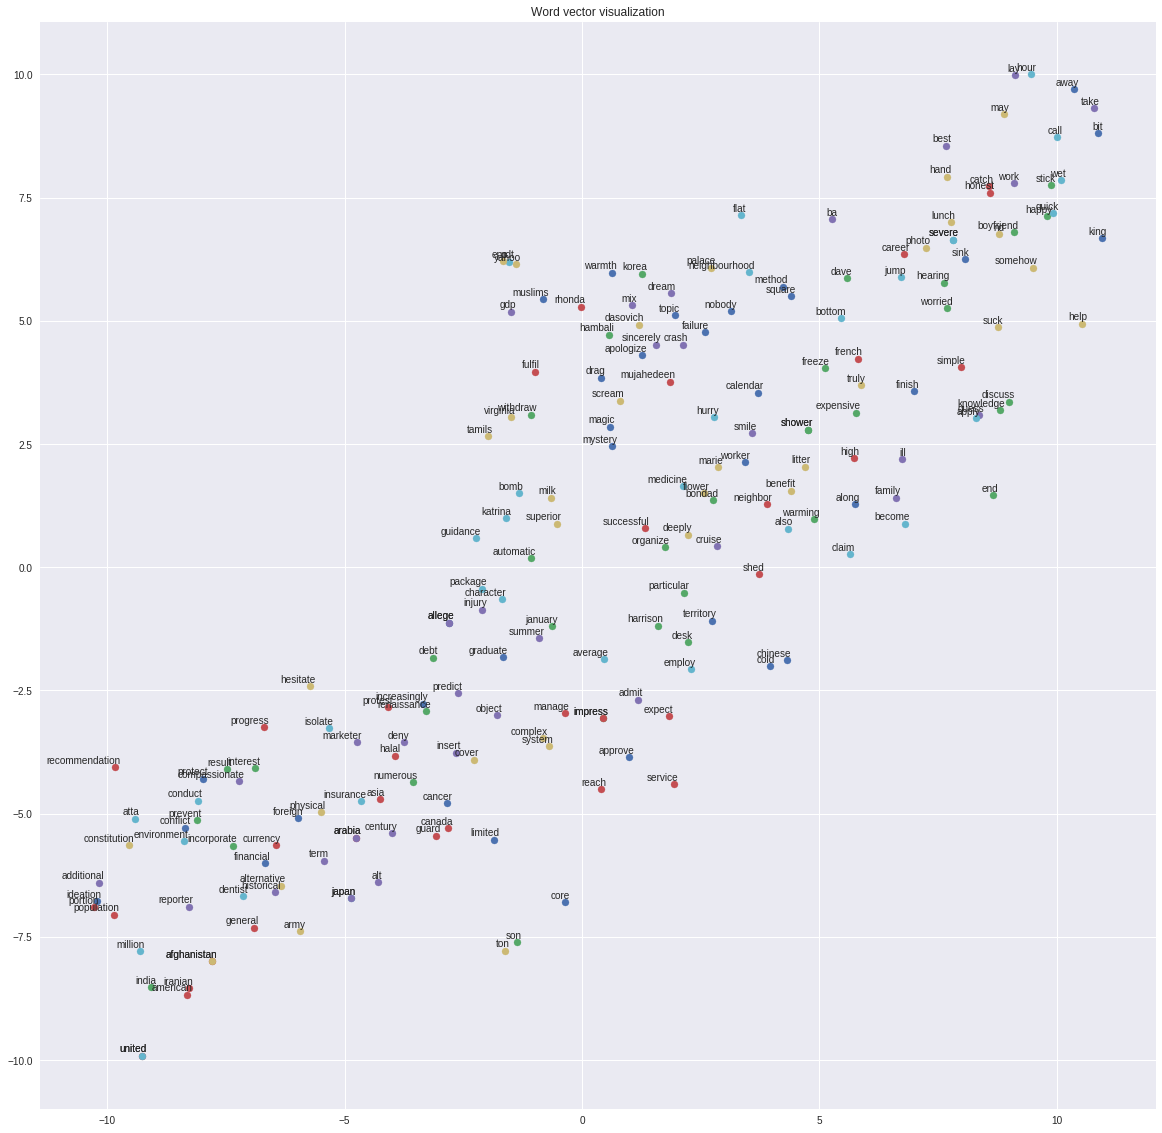

In [0]:
tsne_plot(gs_fasttext.wv, 200)